In [32]:
# CELL 1: SETUP AND IMPORTS
print("="*60)
print("STEP 1: SETUP AND IMPORTS FOR ISOLATION FOREST")
print("="*60)

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
%matplotlib inline

# Set style
try:
    sns.set_style("darkgrid")
    sns.set_palette("husl")
    print("✓ Using seaborn darkgrid style")
except:
    plt.style.use('default')
    print("✓ Using default matplotlib style")

# Create project directories
project_dirs = [
    'data/raw',
    'data/processed',
    'data/test',
    'models/iforest',
    'results/plots',
    'results/detections'
]

for dir_path in project_dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"✓ Created: {dir_path}")

# Scikit-learn imports
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)

print("\n✅ STEP 1 COMPLETE: All imports and directories created")
print(f"Working directory: {os.getcwd()}")

STEP 1: SETUP AND IMPORTS FOR ISOLATION FOREST
✓ Using seaborn darkgrid style
✓ Created: data/raw
✓ Created: data/processed
✓ Created: data/test
✓ Created: models/iforest
✓ Created: results/plots
✓ Created: results/detections

✅ STEP 1 COMPLETE: All imports and directories created
Working directory: c:\Users\xxalv\OneDrive\Desktop\security\isolation-forest


In [33]:
# CELL 2: LOAD IOT ATTACK DATA
print("\n" + "="*60)
print("STEP 2: LOADING YOUR IOT ATTACK DATA")
print("="*60)

# Check what files are available
print("Looking for your IoT attack data files in 'data/raw/'...")
data_files = glob.glob('data/raw/*.csv')
print(f"Found {len(data_files)} CSV files")

if len(data_files) == 0:
    print("⚠️ No CSV files found! Please upload your attack data to 'data/raw/' folder.")
    print("Expected columns:")
    print("Header_Length, Protocol_Type, Time_To_Live, Rate, fin_flag_number, syn_flag_number")
    print("rst_flag_number, psh_flag_number, ack_flag_number, ece_flag_number, cwr_flag_number")
    print("ack_count, syn_count, fin_count, rst_count, HTTP, HTTPS, DNS, Telnet, SMTP, SSH")
    print("IRC, TCP, UDP, DHCP, ARP, ICMP, IGMP, IPv, LLC, Tot_sum, Min, Max, AVG, Std")
    print("Tot_size, IAT, Number, Variance")
    raise FileNotFoundError("No CSV files found in data/raw/")
else:
    # Load all CSV files
    data_frames = []
    for file in data_files:
        print(f"\nLoading {os.path.basename(file)}...")
        try:
            df = pd.read_csv(file)
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {df.columns.tolist()}")
            
            # Check if expected columns are present
            expected_columns = [
                'Header_Length', 'Protocol_Type', 'Time_To_Live', 'Rate',
                'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
                'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
                'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count',
                'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP',
                'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP',
                'IGMP', 'IPv', 'LLC', 'Tot_sum', 'Min', 'Max', 'AVG',
                'Std', 'Tot_size', 'IAT', 'Number', 'Variance'
            ]
            
            # Find which columns are present
            present_columns = [col for col in expected_columns if col in df.columns]
            missing_columns = [col for col in expected_columns if col not in df.columns]
            
            print(f"  Found {len(present_columns)} of {len(expected_columns)} expected columns")
            if missing_columns:
                print(f"  Missing: {missing_columns[:5]}{'...' if len(missing_columns) > 5 else ''}")
            
            data_frames.append(df)
            print(f"  ✓ Loaded {len(df)} records")
            
        except Exception as e:
            print(f"  ✗ Error loading {file}: {e}")
    
    if data_frames:
        abnormal_data = pd.concat(data_frames, ignore_index=True)
        print(f"\n✅ Total attack samples loaded: {len(abnormal_data)}")
    else:
        raise ValueError("No valid CSV files could be loaded")

print("\n📊 YOUR DATA OVERVIEW:")
print(f"Shape: {abnormal_data.shape}")
print(f"\nFirst 3 rows:")
print(abnormal_data.head(3))
print(f"\nMissing values per column:")
missing = abnormal_data.isnull().sum()
print(missing[missing > 0])

print("\n✅ STEP 2 COMPLETE: IoT attack data loaded successfully")


STEP 2: LOADING YOUR IOT ATTACK DATA
Looking for your IoT attack data files in 'data/raw/'...
Found 1 CSV files

Loading DDoS-ACK_Fragmentation.pcap.csv...
  Shape: (25090, 39)
  Columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance']
  Found 36 of 39 expected columns
  Missing: ['Protocol_Type', 'Tot_sum', 'Tot_size']
  ✓ Loaded 25090 records

✅ Total attack samples loaded: 25090

📊 YOUR DATA OVERVIEW:
Shape: (25090, 39)

First 3 rows:
   Header_Length  Protocol Type  Time_To_Live         Rate  fin_flag_number  \
0          12.40              6         67.58  1622.429212              0.0   
1       

In [34]:
# CELL 3: CREATE SYNTHETIC NORMAL DATA
print("\n" + "="*60)
print("STEP 3: CREATING SYNTHETIC NORMAL DATA")
print("="*60)

def create_synthetic_normal_for_iot(df, n_samples=1000):
    """Create synthetic normal-like data for IoT features"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"  Found {len(numeric_cols)} numeric columns")
    
    synthetic_data = []
    
    for _ in range(n_samples):
        sample = {}
        
        for col in numeric_cols:
            col_data = df[col]
            clean_data = col_data.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(clean_data) > 0:
                median_val = clean_data.median()
                std_val = clean_data.std()
                
                if std_val > 0:
                    low_percentile = clean_data.quantile(0.3)
                    value = np.random.normal(low_percentile, std_val * 0.1)
                else:
                    value = median_val
                
                # Apply column-specific bounds
                if 'count' in col.lower() or 'number' in col.lower():
                    value = max(0, min(value, 100))
                elif 'rate' in col.lower():
                    value = max(0, min(value, 100))
                elif 'length' in col.lower() or 'size' in col.lower():
                    value = max(1, min(value, 1500))
                elif 'time' in col.lower() or 'iat' in col.lower():
                    value = max(0.001, min(value, 10))
                elif col in ['Min', 'Max', 'AVG', 'Std', 'Variance']:
                    value = abs(value)
                elif any(proto in col.lower() for proto in ['http', 'https', 'dns', 'ssh', 'tcp', 'udp']):
                    value = 1 if np.random.random() < 0.1 else 0
                
                sample[col] = value
            else:
                sample[col] = 0
        
        synthetic_data.append(sample)
    
    synthetic_df = pd.DataFrame(synthetic_data)
    
    # Ensure we have all columns
    missing_cols = set(df.columns) - set(synthetic_df.columns)
    for col in missing_cols:
        synthetic_df[col] = df[col].iloc[0] if len(df) > 0 else 0
    
    return synthetic_df

# Create synthetic normal data
synthetic_normal = create_synthetic_normal_for_iot(abnormal_data, n_samples=500)
print(f"✅ Created {len(synthetic_normal)} synthetic normal samples")
print(f"Synthetic data shape: {synthetic_normal.shape}")

print("\n📊 STATISTICS COMPARISON:")
print("="*40)
print("ABNORMAL DATA (ATTACKS):")
print(f"  Samples: {len(abnormal_data)}")
print(f"  Avg Rate: {abnormal_data['Rate'].mean():.2f}" if 'Rate' in abnormal_data.columns else "")

print("\nSYNTHETIC NORMAL DATA:")
print(f"  Samples: {len(synthetic_normal)}")
print(f"  Avg Rate: {synthetic_normal['Rate'].mean():.2f}" if 'Rate' in synthetic_normal.columns else "")

print("\nSample of synthetic normal data:")
print(synthetic_normal[['Rate', 'syn_count', 'ack_count', 'TCP', 'UDP']].head(3) 
      if all(col in synthetic_normal.columns for col in ['Rate', 'syn_count', 'ack_count', 'TCP', 'UDP']) 
      else synthetic_normal.head(3))

print("\n✅ STEP 3 COMPLETE: Synthetic normal data created")


STEP 3: CREATING SYNTHETIC NORMAL DATA
  Found 39 numeric columns
✅ Created 500 synthetic normal samples
Synthetic data shape: (500, 39)

📊 STATISTICS COMPARISON:
ABNORMAL DATA (ATTACKS):
  Samples: 25090
  Avg Rate: inf

SYNTHETIC NORMAL DATA:
  Samples: 500
  Avg Rate: 76.17

Sample of synthetic normal data:
    Rate  syn_count  ack_count  TCP  UDP
0  100.0   0.317538  40.222992    0    0
1  100.0   0.000000  43.801841    0    0
2  100.0   0.000000  40.214255    0    0

✅ STEP 3 COMPLETE: Synthetic normal data created


In [35]:
# CELL 4: PREPROCESS DATA
print("\n" + "="*60)
print("STEP 4: PREPROCESSING DATA")
print("="*60)

def preprocess_iot_data(df):
    """Preprocess IoT dataset"""
    df_processed = df.copy()
    print(f"  Original shape: {df_processed.shape}")
    
    # 1. Handle missing values
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                if any(x in col.lower() for x in ['count', 'number', 'rate', 'flag']):
                    df_processed[col] = df_processed[col].fillna(0)
                else:
                    median_val = df_processed[col].median()
                    df_processed[col] = df_processed[col].fillna(median_val)
            else:
                df_processed[col] = df_processed[col].fillna('unknown')
    
    # 2. Handle infinite values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].dtype in [np.float64, np.float32]:
            inf_count = np.isinf(df_processed[col]).sum()
            if inf_count > 0:
                col_max = df_processed[col][~np.isinf(df_processed[col])].max()
                col_min = df_processed[col][~np.isinf(df_processed[col])].min()
                if not np.isnan(col_max) and not np.isnan(col_min):
                    df_processed[col] = df_processed[col].replace(np.inf, col_max * 2)
                    df_processed[col] = df_processed[col].replace(-np.inf, col_min * 2)
                else:
                    df_processed[col] = df_processed[col].replace([np.inf, -np.inf], 0)
    
    # 3. Remove duplicates
    initial_len = len(df_processed)
    df_processed = df_processed.drop_duplicates()
    if len(df_processed) < initial_len:
        print(f"  Removed {initial_len - len(df_processed)} duplicates")
    
    # 4. Handle extreme values
    iot_bounds = {
        'Header_Length': (0, 65535), 'Time_To_Live': (0, 255), 'Rate': (0, 10000),
        'fin_flag_number': (0, 1000), 'syn_flag_number': (0, 10000), 'rst_flag_number': (0, 1000),
        'psh_flag_number': (0, 1000), 'ack_flag_number': (0, 10000), 'ece_flag_number': (0, 100),
        'cwr_flag_number': (0, 100), 'ack_count': (0, 10000), 'syn_count': (0, 10000),
        'fin_count': (0, 1000), 'rst_count': (0, 1000), 'HTTP': (0, 1), 'HTTPS': (0, 1),
        'DNS': (0, 1), 'Telnet': (0, 1), 'SMTP': (0, 1), 'SSH': (0, 1), 'IRC': (0, 1),
        'TCP': (0, 1), 'UDP': (0, 1), 'DHCP': (0, 1), 'ARP': (0, 1), 'ICMP': (0, 1),
        'IGMP': (0, 1), 'IPv': (0, 1), 'LLC': (0, 1), 'Tot_sum': (0, 1e9), 'Min': (0, 10000),
        'Max': (0, 10000), 'AVG': (0, 10000), 'Std': (0, 5000), 'Tot_size': (0, 1e9),
        'IAT': (0, 100), 'Number': (0, 10000), 'Variance': (0, 1e6)
    }
    
    for col in numeric_cols:
        col_lower = col.lower()
        for bound_key, (min_val, max_val) in iot_bounds.items():
            if bound_key.lower() in col_lower:
                outliers = (df_processed[col] > max_val).sum() + (df_processed[col] < min_val).sum()
                if outliers > 0:
                    df_processed[col] = df_processed[col].clip(min_val, max_val)
                break
    
    # 5. Encode categorical variables
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        unique_count = df_processed[col].nunique()
        if unique_count < 50:
            df_processed[col] = pd.factorize(df_processed[col])[0]
        else:
            df_processed = df_processed.drop(col, axis=1)
    
    numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    print(f"  Final shape: {df_processed.shape}")
    print(f"  Using {len(numerical_features)} numerical features")
    
    return df_processed, numerical_features

# Preprocess attack data
print("Preprocessing attack data...")
abnormal_processed, features = preprocess_iot_data(abnormal_data)

# Preprocess synthetic normal data
print("\nPreprocessing synthetic normal data...")
synthetic_normal_processed, _ = preprocess_iot_data(synthetic_normal)

print("\n✅ STEP 4 COMPLETE: Data preprocessing done")


STEP 4: PREPROCESSING DATA
Preprocessing attack data...
  Original shape: (25090, 39)
  Removed 4 duplicates
  Final shape: (25086, 39)
  Using 39 numerical features

Preprocessing synthetic normal data...
  Original shape: (500, 39)
  Final shape: (500, 39)
  Using 39 numerical features

✅ STEP 4 COMPLETE: Data preprocessing done


In [36]:
# CELL 5: FEATURE ENGINEERING
print("\n" + "="*60)
print("STEP 5: FEATURE ENGINEERING FOR IOT ATTACK PATTERNS")
print("="*60)

def engineer_iot_features(df, features_list):
    """Create specialized features for IoT attack detection"""
    print(f"  Starting with {len(features_list)} base features")
    
    df_features = df[features_list].copy()
    
    # 1. Flag ratio features
    flag_cols = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 
                 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number']
    available_flags = [col for col in flag_cols if col in df.columns]
    
    if len(available_flags) >= 2:
        df_features['total_flags'] = df[available_flags].sum(axis=1)
        if 'syn_flag_number' in available_flags:
            df_features['syn_to_total_ratio'] = np.where(
                df_features['total_flags'] > 0,
                df['syn_flag_number'] / df_features['total_flags'],
                0
            )
        if 'ack_flag_number' in available_flags:
            df_features['ack_to_total_ratio'] = np.where(
                df_features['total_flags'] > 0,
                df['ack_flag_number'] / df_features['total_flags'],
                0
            )
    
    # 2. Protocol interaction features
    protocol_cols = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 
                    'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC']
    available_protocols = [col for col in protocol_cols if col in df.columns]
    
    if len(available_protocols) >= 2:
        df_features['active_protocols'] = df[available_protocols].sum(axis=1)
        if all(col in df.columns for col in ['TCP', 'UDP']):
            df_features['tcp_udp_both'] = ((df['TCP'] > 0) & (df['UDP'] > 0)).astype(int)
        if all(col in df.columns for col in ['ICMP', 'Rate']):
            df_features['icmp_flood_suspicion'] = ((df['ICMP'] > 0) & (df['Rate'] > 1000)).astype(int)
    
    # 3. Statistical anomaly features
    if all(col in df.columns for col in ['Std', 'AVG']):
        df_features['coeff_variation'] = np.where(
            df['AVG'] > 0,
            df['Std'] / df['AVG'],
            0
        )
        df_features['high_variance'] = (df['Std'] > 3 * df['AVG']).astype(int)
    
    if all(col in df.columns for col in ['Max', 'Min']):
        df_features['value_range'] = df['Max'] - df['Min']
    
    # 4. Rate-based features
    if 'Rate' in df.columns:
        df_features['rate_category'] = pd.cut(df['Rate'], 
                                              bins=[-1, 10, 100, 1000, 10000, float('inf')],
                                              labels=['very_low', 'low', 'medium', 'high', 'very_high'])
        df_features['rate_category'] = pd.factorize(df_features['rate_category'])[0]
        rate_q75 = df['Rate'].quantile(0.75)
        rate_q25 = df['Rate'].quantile(0.25)
        iqr = rate_q75 - rate_q25
        upper_bound = rate_q75 + 1.5 * iqr
        df_features['rate_outlier'] = (df['Rate'] > upper_bound).astype(int)
    
    # 5. Time-based features
    if 'IAT' in df.columns:
        df_features['log_iat'] = np.log1p(df['IAT'])
        df_features['iat_reciprocal'] = np.where(df['IAT'] > 0, 1 / df['IAT'], 0)
        iat_threshold = df['IAT'].quantile(0.1)
        df_features['low_iat_burst'] = (df['IAT'] < iat_threshold).astype(int)
    
    # 6. Composite attack indicators
    if all(col in df.columns for col in ['syn_flag_number', 'Rate']):
        syn_threshold = df['syn_flag_number'].quantile(0.9)
        rate_threshold = df['Rate'].quantile(0.9)
        df_features['syn_flood_indicator'] = (
            (df['syn_flag_number'] > syn_threshold) & 
            (df['Rate'] > rate_threshold)
        ).astype(int)
    
    if 'Rate' in df.columns and 'active_protocols' in df_features.columns:
        rate_threshold = df['Rate'].quantile(0.9)
        protocol_threshold = df_features['active_protocols'].quantile(0.9)
        df_features['ddos_indicator'] = (
            (df['Rate'] > rate_threshold) & 
            (df_features['active_protocols'] > protocol_threshold)
        ).astype(int)
    
    if 'active_protocols' in df_features.columns:
        scan_threshold = df_features['active_protocols'].quantile(0.95)
        df_features['port_scan_indicator'] = (
            df_features['active_protocols'] > scan_threshold
        ).astype(int)
    
    # Fill NaN and infinite values
    df_features = df_features.fillna(0)
    for col in df_features.columns:
        if pd.api.types.is_numeric_dtype(df_features[col]):
            df_features[col] = df_features[col].replace([np.inf, -np.inf], 0)
    
    print(f"  Final feature matrix shape: {df_features.shape}")
    print(f"  Total features created: {len(df_features.columns)}")
    
    return df_features

# Apply feature engineering
print("Engineering features for attack data...")
X_abnormal = engineer_iot_features(abnormal_processed, features)
print(f"✅ Attack features shape: {X_abnormal.shape}")

print("\nEngineering features for synthetic normal data...")
X_synthetic_normal = engineer_iot_features(synthetic_normal_processed, features)
print(f"✅ Synthetic normal features shape: {X_synthetic_normal.shape}")

# Save feature information
print("\n💾 Saving feature information...")
all_features = list(X_abnormal.columns)
joblib.dump(all_features, 'models/iforest/all_features.pkl')

print(f"\n📊 ENGINEERED FEATURES SUMMARY:")
print(f"Total features: {len(all_features)}")
print(f"Base features: {len(features)}")
print(f"Engineered features: {len(all_features) - len(features)}")

print("\n✅ STEP 5 COMPLETE: Feature engineering done")


STEP 5: FEATURE ENGINEERING FOR IOT ATTACK PATTERNS
Engineering features for attack data...
  Starting with 39 base features
  Final feature matrix shape: (25086, 56)
  Total features created: 56
✅ Attack features shape: (25086, 56)

Engineering features for synthetic normal data...
  Starting with 39 base features
  Final feature matrix shape: (500, 56)
  Total features created: 56
✅ Synthetic normal features shape: (500, 56)

💾 Saving feature information...

📊 ENGINEERED FEATURES SUMMARY:
Total features: 56
Base features: 39
Engineered features: 17

✅ STEP 5 COMPLETE: Feature engineering done


In [37]:
# CELL 6: SCALE FEATURES
print("\n" + "="*60)
print("STEP 6: SCALING FEATURES")
print("="*60)

scaler = StandardScaler()

# Clean data
X_abnormal_clean = X_abnormal.fillna(0).replace([np.inf, -np.inf], 0)
X_synthetic_clean = X_synthetic_normal.fillna(0).replace([np.inf, -np.inf], 0)

X_abnormal_array = X_abnormal_clean.values
X_synthetic_array = X_synthetic_clean.values

print(f"Attack array shape: {X_abnormal_array.shape}")
print(f"Synthetic array shape: {X_synthetic_array.shape}")

# Fit scaler on abnormal data
print("\nFitting StandardScaler on attack data...")
X_abnormal_scaled = scaler.fit_transform(X_abnormal_array)
print(f"✅ Attack data scaled: {X_abnormal_scaled.shape}")

# Transform synthetic normal data
print("Transforming synthetic normal data...")
X_synthetic_normal_scaled = scaler.transform(X_synthetic_array)
print(f"✅ Synthetic normal data scaled: {X_synthetic_normal_scaled.shape}")

# Save the scaler
scaler_path = 'models/iforest/iot_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to '{scaler_path}'")

# Save feature names
feature_names_path = 'models/iforest/iot_feature_names.pkl'
joblib.dump(list(X_abnormal.columns), feature_names_path)
print(f"✅ Feature names saved to '{feature_names_path}'")

print("\n✅ STEP 6 COMPLETE: Features scaled successfully")


STEP 6: SCALING FEATURES
Attack array shape: (25086, 56)
Synthetic array shape: (500, 56)

Fitting StandardScaler on attack data...
✅ Attack data scaled: (25086, 56)
Transforming synthetic normal data...
✅ Synthetic normal data scaled: (500, 56)
✅ Scaler saved to 'models/iforest/iot_scaler.pkl'
✅ Feature names saved to 'models/iforest/iot_feature_names.pkl'

✅ STEP 6 COMPLETE: Features scaled successfully


In [38]:
# CELL 7: TRAIN ISOLATION FOREST MODEL
print("\n" + "="*60)
print("STEP 7: TRAINING ISOLATION FOREST MODEL")
print("="*60)

# Split data for training and testing
print("Splitting data for training and testing...")
X_train, X_test_abnormal = train_test_split(
    X_abnormal_scaled, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"Training samples: {X_train.shape[0]:,}")
print(f"Testing samples (attacks): {X_test_abnormal.shape[0]:,}")
print(f"Feature dimensions: {X_train.shape[1]}")

# Prepare synthetic normal data for testing
normal_test_size = min(len(X_test_abnormal), len(X_synthetic_normal_scaled))
X_test_normal = X_synthetic_normal_scaled[:normal_test_size]
print(f"Testing samples (synthetic normal): {normal_test_size:,}")

# Train Isolation Forest
print("\n" + "-"*50)
print("TRAINING ISOLATION FOREST FOR IOT ATTACK DETECTION")
print("-"*50)
print("Model will learn normal attack patterns")
print("Anomalies will be flagged as outliers")

# Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.1,  # Expected proportion of outliers
    max_features=1.0,
    bootstrap=False,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\nStarting training...")
iso_forest.fit(X_train)
print("✅ Training completed!")

# Save the model
model_path = 'models/iforest/iso_forest_iot.pkl'
joblib.dump(iso_forest, model_path)
print(f"✅ Model saved to '{model_path}'")

# Model information
print("\n📋 ISOLATION FOREST MODEL INFORMATION:")
print(f"Algorithm: Isolation Forest")
print(f"Number of estimators: {iso_forest.n_estimators}")
print(f"Contamination: {iso_forest.contamination}")
print(f"Max samples: {iso_forest.max_samples}")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Features: {X_train.shape[1]}")

print("\n✅ STEP 7 COMPLETE: Isolation Forest model trained successfully")


STEP 7: TRAINING ISOLATION FOREST MODEL
Splitting data for training and testing...
Training samples: 20,068
Testing samples (attacks): 5,018
Feature dimensions: 56
Testing samples (synthetic normal): 500

--------------------------------------------------
TRAINING ISOLATION FOREST FOR IOT ATTACK DETECTION
--------------------------------------------------
Model will learn normal attack patterns
Anomalies will be flagged as outliers

Starting training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


✅ Training completed!
✅ Model saved to 'models/iforest/iso_forest_iot.pkl'

📋 ISOLATION FOREST MODEL INFORMATION:
Algorithm: Isolation Forest
Number of estimators: 100
Contamination: 0.1
Max samples: auto
Training samples: 20,068
Features: 56

✅ STEP 7 COMPLETE: Isolation Forest model trained successfully


In [39]:
# CELL 8: EVALUATE MODEL
print("\n" + "="*60)
print("STEP 8: EVALUATING ISOLATION FOREST PERFORMANCE")
print("="*60)

# Predict on attack test data (should be predicted as normal/inliers)
print("Predicting on attack test data...")
abnormal_predictions = iso_forest.predict(X_test_abnormal)
abnormal_scores = iso_forest.decision_function(X_test_abnormal)

# Predict on synthetic normal data (should be predicted as outliers)
print("Predicting on synthetic normal test data...")
normal_predictions = iso_forest.predict(X_test_normal)
normal_scores = iso_forest.decision_function(X_test_normal)

print("\n📊 PREDICTION RESULTS:")
print("-" * 40)

# Attack predictions
abnormal_normal_count = np.sum(abnormal_predictions == 1)
abnormal_outlier_count = np.sum(abnormal_predictions == -1)
print("ATTACK TEST DATA:")
print(f"  Predicted as normal (1): {abnormal_normal_count:,} samples")
print(f"  Predicted as outlier (-1): {abnormal_outlier_count:,} samples")
print(f"  % predicted as normal: {abnormal_normal_count/len(abnormal_predictions):.2%}")

# Normal predictions
normal_normal_count = np.sum(normal_predictions == 1)
normal_outlier_count = np.sum(normal_predictions == -1)
print("\nSYNTHETIC NORMAL DATA:")
print(f"  Predicted as normal (1): {normal_normal_count:,} samples")
print(f"  Predicted as outlier (-1): {normal_outlier_count:,} samples")
print(f"  % predicted as outlier: {normal_outlier_count/len(normal_predictions):.2%}")

# Calculate performance metrics
print("\n📈 PERFORMANCE METRICS:")
print("-" * 40)

# True labels: 1 = attacks (inliers), 0 = normal (outliers)
y_true = np.concatenate([
    np.ones(len(abnormal_predictions)),  # Attacks = 1
    np.zeros(len(normal_predictions))    # Normal = 0
])

# Predictions: Convert to 1 = normal (1), 0 = outlier (-1)
y_pred_labels = np.concatenate([
    np.where(abnormal_predictions == 1, 1, 0),  # Attacks should be 1
    np.where(normal_predictions == 1, 1, 0)     # Normal should be 0
])

# Decision scores for ROC
y_scores = np.concatenate([abnormal_scores, normal_scores])

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels, zero_division=0)
recall = recall_score(y_true, y_pred_labels, zero_division=0)
f1 = f1_score(y_true, y_pred_labels, zero_division=0)

# ROC AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"  Accuracy: {accuracy:.2%}")
print(f"  Precision: {precision:.2%}")
print(f"  Recall: {recall:.2%}")
print(f"  F1-Score: {f1:.2%}")
print(f"  ROC AUC: {roc_auc:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
print(f"\n🔢 CONFUSION MATRIX:")
print(f"                 Predicted")
print(f"               Normal  Outlier")
print(f"Actual Normal  {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"       Attack  {cm[1,0]:6d}  {cm[1,1]:6d}")

# Save metrics
metrics_dict = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'roc_auc': float(roc_auc),
    'confusion_matrix': cm.tolist(),
    'predictions_summary': {
        'attacks_total': len(abnormal_predictions),
        'attacks_predicted_normal': int(abnormal_normal_count),
        'attacks_predicted_outlier': int(abnormal_outlier_count),
        'normal_total': len(normal_predictions),
        'normal_predicted_normal': int(normal_normal_count),
        'normal_predicted_outlier': int(normal_outlier_count)
    }
}

with open('results/iforest_model_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"\n✅ Metrics saved to 'results/iforest_model_metrics.json'")
print("\n✅ STEP 8 COMPLETE: Model evaluated")


STEP 8: EVALUATING ISOLATION FOREST PERFORMANCE
Predicting on attack test data...
Predicting on synthetic normal test data...

📊 PREDICTION RESULTS:
----------------------------------------
ATTACK TEST DATA:
  Predicted as normal (1): 4,495 samples
  Predicted as outlier (-1): 523 samples
  % predicted as normal: 89.58%

SYNTHETIC NORMAL DATA:
  Predicted as normal (1): 403 samples
  Predicted as outlier (-1): 97 samples
  % predicted as outlier: 19.40%

📈 PERFORMANCE METRICS:
----------------------------------------
  Accuracy: 83.22%
  Precision: 91.77%
  Recall: 89.58%
  F1-Score: 90.66%
  ROC AUC: 83.03%

🔢 CONFUSION MATRIX:
                 Predicted
               Normal  Outlier
Actual Normal      97     403
       Attack     523    4495

✅ Metrics saved to 'results/iforest_model_metrics.json'

✅ STEP 8 COMPLETE: Model evaluated


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished



STEP 9: VISUALIZING ISOLATION FOREST RESULTS
Generating visualizations...
✅ Visualization saved to 'results/plots/iforest_attack_detection_results.png'


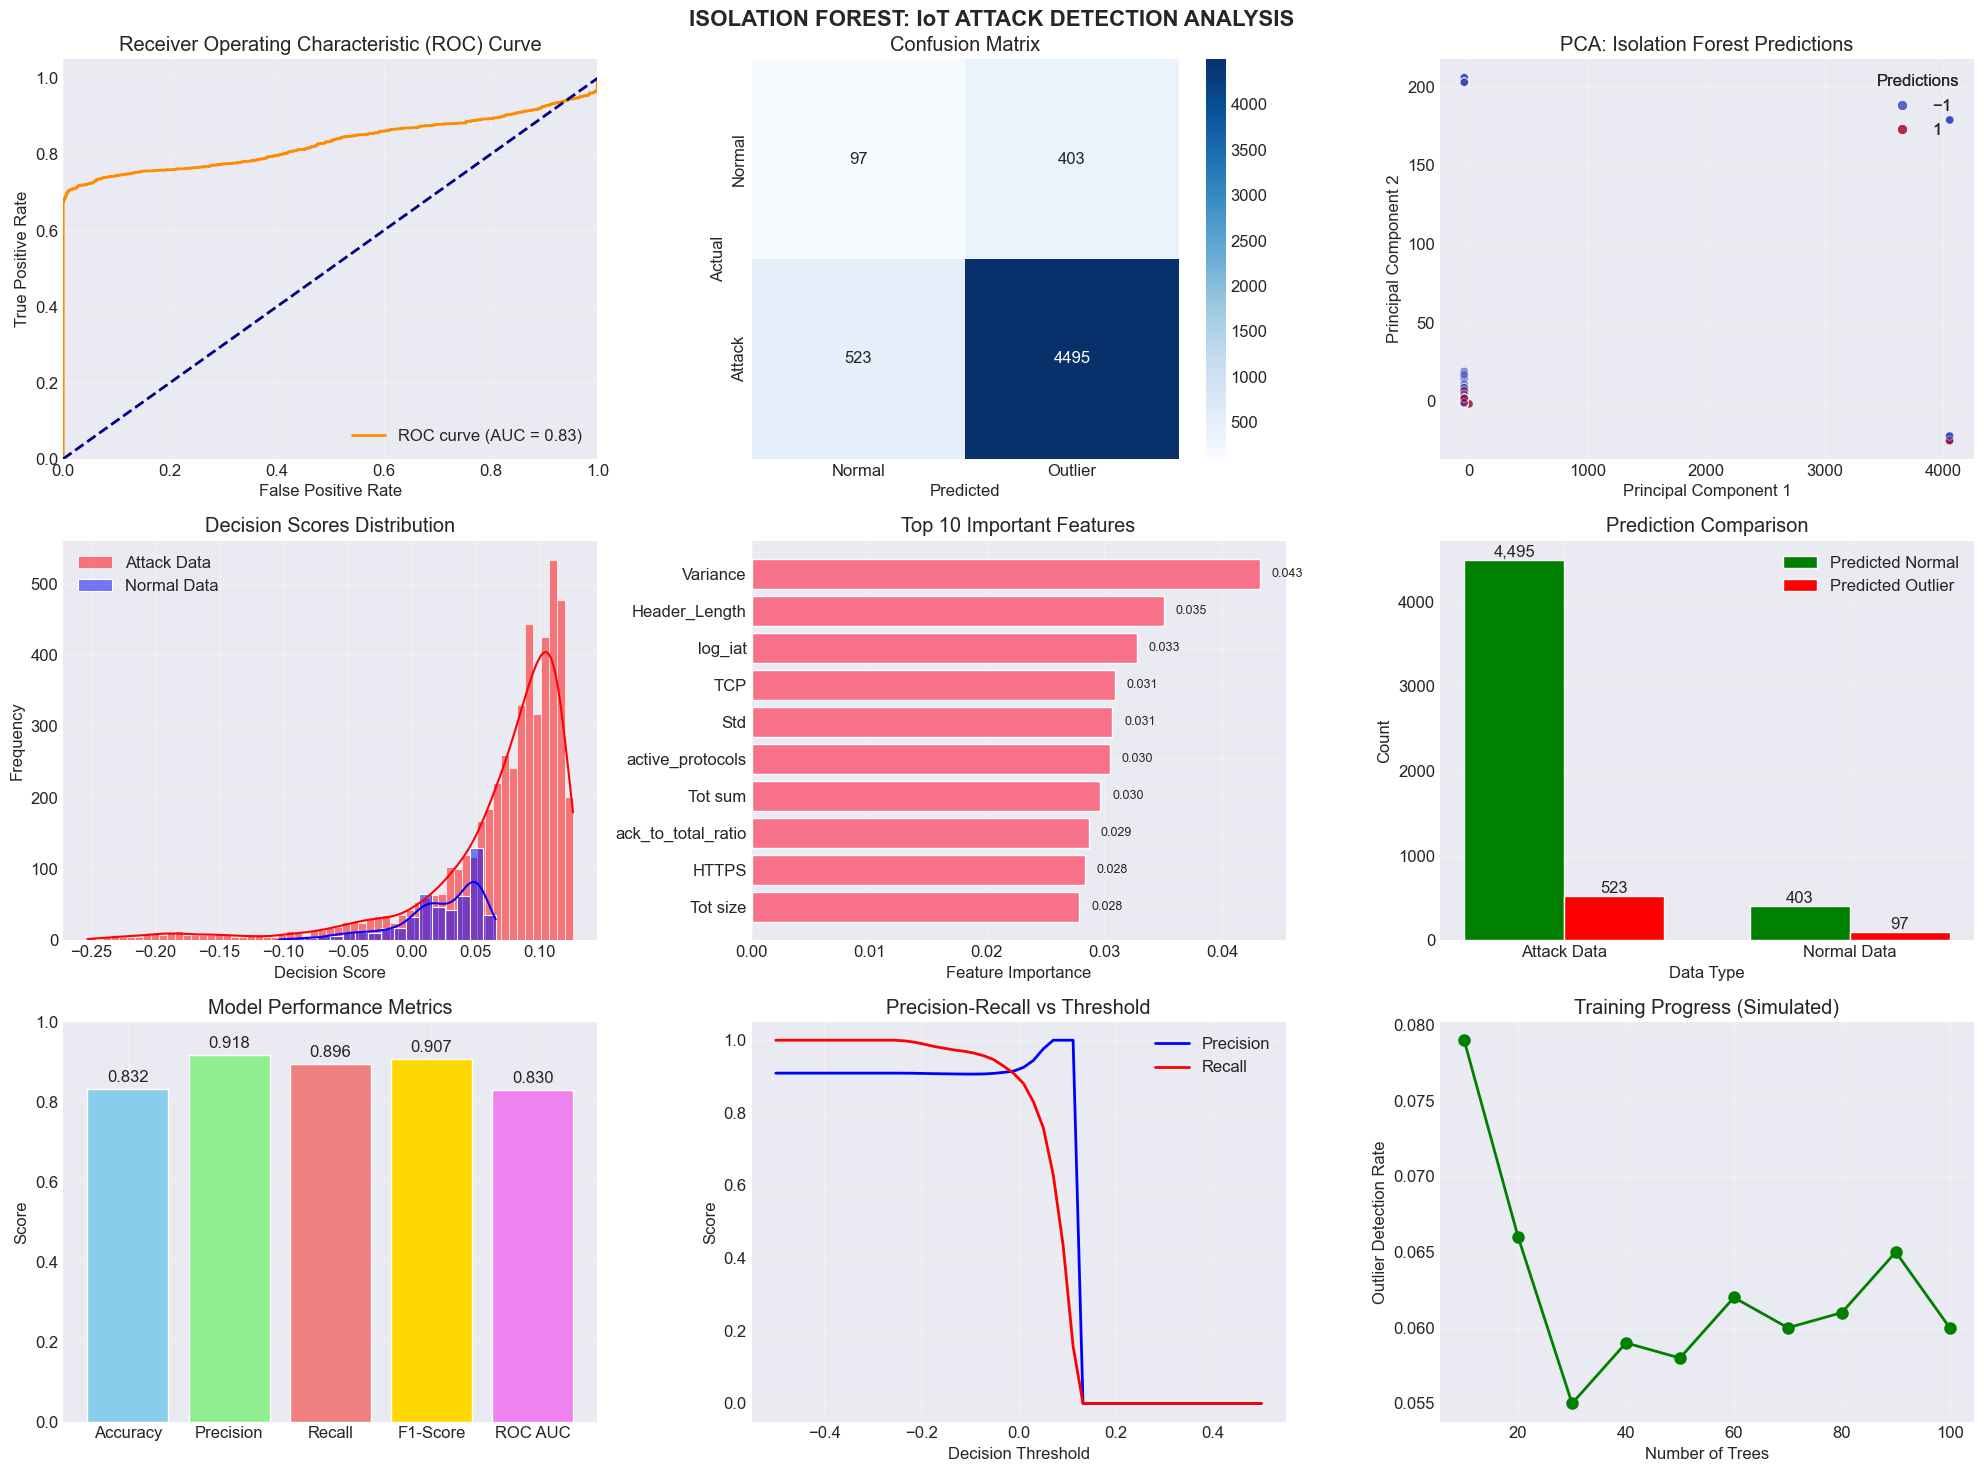


✅ STEP 9 COMPLETE: Visualizations generated


In [40]:
# CELL 9: VISUALIZE RESULTS
print("\n" + "="*60)
print("STEP 9: VISUALIZING ISOLATION FOREST RESULTS")
print("="*60)

print("Generating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(20, 15))

# 1. ROC Curve
ax1 = plt.subplot(3, 3, 1)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix Heatmap
ax2 = plt.subplot(3, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Normal', 'Outlier'],
            yticklabels=['Normal', 'Attack'])
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix')

# 3. PCA Visualization
ax3 = plt.subplot(3, 3, 3)
# Combine test data
X_combined = np.vstack([X_test_abnormal, X_test_normal])
y_combined_labels = np.concatenate([abnormal_predictions, normal_predictions])
y_combined_true = np.concatenate([np.ones(len(X_test_abnormal)), np.zeros(len(X_test_normal))])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Scatter plot
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=y_combined_labels, cmap='coolwarm', 
                      alpha=0.6, edgecolors='w', linewidth=0.5)
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_title('PCA: Isolation Forest Predictions')
ax3.grid(True, alpha=0.3)
legend1 = ax3.legend(*scatter.legend_elements(),
                    title="Predictions", loc="upper right")
ax3.add_artist(legend1)

# 4. Decision Scores Distribution
ax4 = plt.subplot(3, 3, 4)
sns.histplot(data=abnormal_scores, label='Attack Data', kde=True, color='red', alpha=0.5, ax=ax4)
sns.histplot(data=normal_scores, label='Normal Data', kde=True, color='blue', alpha=0.5, ax=ax4)
ax4.set_xlabel('Decision Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Decision Scores Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Feature Importance (based on isolation path length)
ax5 = plt.subplot(3, 3, 5)
# Get feature importances from Isolation Forest
feature_importances = np.mean([tree.feature_importances_ for tree in iso_forest.estimators_], axis=0)
top_features_idx = np.argsort(feature_importances)[-10:]  # Top 10 features
top_features_names = [all_features[i] for i in top_features_idx]
top_importances = feature_importances[top_features_idx]

bars = ax5.barh(range(len(top_features_names)), top_importances)
ax5.set_yticks(range(len(top_features_names)))
ax5.set_yticklabels(top_features_names)
ax5.set_xlabel('Feature Importance')
ax5.set_title('Top 10 Important Features')
for i, (bar, importance) in enumerate(zip(bars, top_importances)):
    ax5.text(importance + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.3f}', va='center', ha='left', fontsize=9)

# 6. Prediction Comparison
ax6 = plt.subplot(3, 3, 6)
categories = ['Attack Data', 'Normal Data']
normal_counts = [abnormal_normal_count, normal_normal_count]
outlier_counts = [abnormal_outlier_count, normal_outlier_count]

x = np.arange(len(categories))
width = 0.35

bars1 = ax6.bar(x - width/2, normal_counts, width, label='Predicted Normal', color='green')
bars2 = ax6.bar(x + width/2, outlier_counts, width, label='Predicted Outlier', color='red')

ax6.set_xlabel('Data Type')
ax6.set_ylabel('Count')
ax6.set_title('Prediction Comparison')
ax6.set_xticks(x)
ax6.set_xticklabels(categories)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom')

# 7. Metrics Bar Chart
ax7 = plt.subplot(3, 3, 7)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet']

bars = ax7.bar(metrics_names, metrics_values, color=colors)
ax7.set_ylabel('Score')
ax7.set_title('Model Performance Metrics')
ax7.set_ylim([0, 1])
ax7.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom')

# 8. Threshold Analysis
ax8 = plt.subplot(3, 3, 8)
# Calculate precision-recall for different thresholds
thresholds = np.linspace(-0.5, 0.5, 50)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = (y_scores >= threshold).astype(int)
    precisions.append(precision_score(y_true, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_true, y_pred_thresh, zero_division=0))

ax8.plot(thresholds, precisions, 'b-', label='Precision', lw=2)
ax8.plot(thresholds, recalls, 'r-', label='Recall', lw=2)
ax8.set_xlabel('Decision Threshold')
ax8.set_ylabel('Score')
ax8.set_title('Precision-Recall vs Threshold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Training Progress (simulated)
ax9 = plt.subplot(3, 3, 9)
# Simulate training error (in practice, you'd track this during training)
n_estimators_range = np.arange(10, 110, 10)
train_errors = []
for n in n_estimators_range:
    model = IsolationForest(n_estimators=n, random_state=42)
    model.fit(X_train[:1000])  # Use subset for speed
    preds = model.predict(X_train[:1000])
    error = np.mean(preds == -1)  # Proportion detected as outliers
    train_errors.append(error)

ax9.plot(n_estimators_range, train_errors, 'g-o', lw=2, markersize=8)
ax9.set_xlabel('Number of Trees')
ax9.set_ylabel('Outlier Detection Rate')
ax9.set_title('Training Progress (Simulated)')
ax9.grid(True, alpha=0.3)

plt.suptitle('ISOLATION FOREST: IoT ATTACK DETECTION ANALYSIS', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
plot_path = 'results/plots/iforest_attack_detection_results.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved to '{plot_path}'")

plt.show()
print("\n✅ STEP 9 COMPLETE: Visualizations generated")

In [45]:
# SIMPLE VERSION: TEST SINGLE FILE
print("="*60)
print("QUICK ATTACK DETECTION")
print("="*60)

import pandas as pd
import numpy as np
import joblib

# Load everything
model = joblib.load('models/iforest/iso_forest_iot.pkl')
scaler = joblib.load('models/iforest/iot_scaler.pkl')
features = joblib.load('models/iforest/iot_feature_names.pkl')

# Check for test files
import glob
test_files = glob.glob('data/test/*.csv')

if not test_files:
    print("No test files found! Put your CSV in 'data/test/' folder")
else:
    for file in test_files:
        print(f"\nChecking: {file}")
        
        # Load data
        df = pd.read_csv(file)
        
        # Simple preprocessing
        df = df.fillna(0).replace([np.inf, -np.inf], 0)
        
        # Select only numeric columns that match our features
        numeric_df = df.select_dtypes(include=[np.number])
        
        # Add missing features
        for col in features:
            if col not in numeric_df.columns:
                numeric_df[col] = 0
        
        # Keep only needed features
        X = numeric_df[features].values
        
        # Scale and predict
        X_scaled = scaler.transform(X)
        predictions = model.predict(X_scaled)
        
        # Count results
        attacks = sum(predictions == -1)
        normal = sum(predictions == 1)
        total = len(predictions)
        
        print(f"Results:")
        print(f"  Attack: {normal} ({normal/total*100:.1f}%)")
        print(f"  Normal: {attacks} ({attacks/total*100:.1f}%)")
        
        if attacks > 0:
            print("⚠️  ATTACK DETECTED!")
        else:
            print("✅  No attacks detected")

QUICK ATTACK DETECTION

Checking: data/test\DDoS-ICMP_Flood.pcap.csv
Results:
  Attack: 20214 (80.6%)
  Normal: 4876 (19.4%)
⚠️  ATTACK DETECTED!


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
